### Elevation profiles extracted from SRTM over Mt Baker compared with ICESat-2

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

In [9]:
data_dir = '/home/jovyan/data/nsidc/**/'

In [14]:
files = []
for f in glob.glob(data_dir + "*.h5"):
    # append full filename to list of filenames
    files.append(f)  
files.sort()

In [11]:
def ATL06_to_dict(filename, dataset_dict):  
    D6=[]
    pairs=[1, 2, 3]
    beams=['l','r']
    # open the HDF5 file
    with h5py.File(filename) as h5f:
        # loop over beam pairs
        for pair in pairs:
            # loop over beams
            for beam_ind, beam in enumerate(beams):
                # check if a beam exists, if not, skip it
                if '/gt%d%s/land_ice_segments' % (pair, beam) not in h5f:
                    continue
                # loop over the groups in the dataset dictionary
                temp={}
                for group in dataset_dict.keys():
                    for dataset in dataset_dict[group]:
                        DS='/gt%d%s/%s/%s' % (pair, beam, group, dataset)
                        # since a dataset may not exist in a file, we're going to try to read it, and if it doesn't work, we'll move on to the next:
                        try:
                            temp[dataset]=np.array(h5f[DS])
                            # some parameters have a _FillValue attribute.  If it exists, use it to identify bad values, and set them to np.NaN
                            if '_FillValue' in h5f[DS].attrs:
                                fill_value=h5f[DS].attrs['_FillValue']
                                
                                bad=temp[dataset]==fill_value
                                temp[dataset]=np.float32(temp[dataset])
                                temp[dataset][bad]=np.NaN
#                                 temp[dataset][temp[dataset]==fill_value]=np.NaN
                        except KeyError as e:
                            pass
                        except TypeError:
                            print(type(fill_value))
                if len(temp) > 0:
                    # it's sometimes convenient to have the beam and the pair as part of the output data structure: This is how we put them there.
                    temp['pair']=np.zeros_like(temp['h_li'])+pair
                    temp['beam']=np.zeros_like(temp['h_li'])+beam_ind
                    temp['filename']=filename
                    D6.append(temp)
    return D6

In [12]:
dataset_dict={'land_ice_segments':['h_li',
                                   'delta_time',
                                   'longitude',
                                   'latitude'],
              'land_ice_segments/ground_track':['x_atc']}

In [15]:
D6=[]
pairs=[1, 2, 3]
beams=['l','r']

for file in files:
#     this_name=os.path.basename(file)
    D6 += ATL06_to_dict(file, dataset_dict)

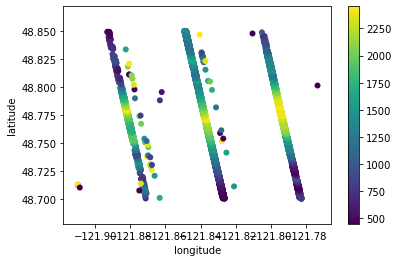

In [18]:
plt.figure();
for Di in D6:
    plt.scatter(Di['longitude'], Di['latitude'], c=Di['h_li'], 
                #vmin=0, vmax=2000, 
                linewidth=0)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar();

In [20]:
# for file in files:
#     this_D6=ATL06_to_dict(file, dataset_dict)
#     plt.figure()
#     plt.plot(this_D6[1]['delta_time'], this_D6[1]['h_li'],'.')
#     plt.title(this_D6[1]['filename'])